In [1]:
from __future__ import print_function
import os
import cv2
import numpy as np
import csv
from PIL import Image
from matplotlib import pyplot as plt

#from sklearn.model_selection import GridSearchCV
#from sklearn.svm import SVC
from sklearn.decomposition import PCA

#from sklearn.metrics import accuracy_score
from math import hypot

import numba
from numba import jit, cuda 

from keras.utils import to_categorical
import tensorflow.keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten,Conv2D,MaxPooling2D
from tensorflow.keras.optimizers import RMSprop, Adam, Nadam
from tensorflow.keras.regularizers import l2


Using TensorFlow backend.


In [2]:
def edit_csvfiles(directory):
    inputfile = csv.reader(open(directory + '\\DefectResult.csv','r'))
    outputfile = open(directory + '\\DefectResult_edited.csv','w')

    line = 0
    for row in inputfile:
        #print("Line", line)
        for i in range(0, len(row)):
            #print(row[i])
            if i == 5 and line == 0 and row[i] == "Bottom":
                print("CSV file is normal")
                outputfile.write(row[i])
                continue
            elif i == 5 and line == 0:
                #print(row[i])
                #print("writing Bottom")
                attributes = row[i].replace('Bottom','Bottom\n')
                outputfile.write(attributes)
                outputfile.write(",")
            elif i < len(row)-1:
                outputfile.write(row[i])
                outputfile.write(",")
            elif i == len(row)-1:
                outputfile.write(row[i])
        outputfile.write("\n")
        line +=1


#ex = os.getcwd() + "\AllLenses" + "\\Allframedata1" + "\\00000012"
#edit_csvfiles(ex)


In [3]:
@jit
def old_mask(img):
    bad = False
    img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

    #                 CROP
    x_start = 50
    y_start = 50
    crop_img = img[y_start:y_start+1255, x_start:x_start+1250]
    #                 RESIZE CROPPED
    scale_percent = 50 #was 50. can't detect circles at 25%
    width = int(crop_img.shape[1] * scale_percent / 100)
    height = int(crop_img.shape[0] * scale_percent / 100)
    dsize = (width, height)
    img = cv2.resize(crop_img, dsize)

    img = cv2.medianBlur(img,5)
    cimg = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
    #print("Hough Circles")
    circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, 1, 400, param1=50, param2=25, minRadius=150, maxRadius=0)
    #print("Houghed")
    circles = np.uint16(np.around(circles))
    for i in circles[0,:]:
        cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
        cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)


    #print("width, height", width, height)
    x, y, r = circles[0,:][0]
    
    if x<width*0.35 or x > width*0.65 or y<height*0.35 or y > height*0.65:
        print("x,y:",x,y)
        bad = True
        plt.imshow(cimg, cmap = 'gray', interpolation = 'bicubic')
        plt.show()
        
    rows, cols = img.shape

    for i in range(cols):
        for j in range(rows):
            if hypot(i-x, j-y) > r:
                img[j,i] = 0
                
    img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    #plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
    #plt.show()
    
    return img, bad


In [4]:
@jit
def load_images_from_folder(folder, key):
    listofFiles = os.listdir(folder)
    for filename in listofFiles:
        joinedFilePath = os.path.join(folder,filename)
        if key =="RGB":
            img = cv2.imread(joinedFilePath)
            #print("RGB")
        elif key == "Grayscale":
            img = cv2.imread(joinedFilePath, 0)
        if img is not None and filename == "PRT_000001_L1.jpg":
            #print("masking")
            img, bad = old_mask(img)
            print("Loaded image from", folder)
            
            return img, bad

#ex = os.getcwd() + "\AllLenses" + "\\Allframedata4" + "\\00000128"
#load_images_from_folder(ex, "Grayscale")


In [5]:
def rotate(image, angle, scale=1.0):
        w = image.shape[1]
        h = image.shape[0]
        #rotate matrix
        M = cv2.getRotationMatrix2D((w/2,h/2), angle, scale)
        #rotate
        image = cv2.warpAffine(image,M,(w,h))
        return image

In [6]:
def flip(image, vflip, hflip):
        if hflip or vflip:
            if hflip and vflip:
                c = -1
            else:
                c = 0 if vflip else 1
            image = cv2.flip(image, flipCode=c)
        return image 

In [7]:
def get_labels(folder):
    defect = "불량" #1
    reserved = "보류" #2
    normal = "정상" #0
    target = folder + "\\" + 'DefectResult_edited.csv'
    label = "N/A"
    
    if os.path.exists(target):
        with open(target) as fin:
            reader = csv.reader(fin)
            next(reader)
            for row in reader:
                if defect in row[1:2]:
                    label = 1 # 2 to 1
                    break
                elif reserved in row:
                    label = 2 #1 to 2
                elif normal in row:
                    label = 0         
    else:
        print("DefectResult_edited.csv was not found in ", folder)

    return label

In [8]:
@jit
def getImagesandLabels(path, folders):

    images = []
    labels = []
    folder= path

    for i in range(0, len(folders)):
        folder= path + "\\" + folders[i]
        edit_csvfiles(folder) #run once only
        result, bad = load_images_from_folder(folder, "RGB") #choose "RGB" or "Grayscale"
        the_label = get_labels(folder)
        
        if (the_label == 2):
            print("skipping 보류")
            continue
        if (bad ==True):
            print("BAD IMAGE")
            continue
        print("Label:", the_label)
        images.append(result)
        labels.append(the_label)
        
        if the_label == 2:            
            images.append(rotate(result, angle=90, scale=1.0))
            labels.append(the_label)

            images.append(rotate(result, angle=180, scale=1.0))
            labels.append(the_label)
            
            images.append(rotate(result, angle=270, scale=1.0))
            labels.append(the_label)
            
        if the_label == 1:
            images.append(rotate(result, angle=22.5, scale=1.0))
            labels.append(the_label)
            
            images.append(rotate(result, angle=45, scale=1.0))
            labels.append(the_label)
            
            images.append(rotate(result, angle=67.5, scale=1.0))
            labels.append(the_label)
            
            images.append(rotate(result, angle=90, scale=1.0))
            labels.append(the_label)
            
            images.append(rotate(result, angle=112.5, scale=1.0))
            labels.append(the_label)
            
            images.append(rotate(result, angle=135, scale=1.0))
            labels.append(the_label)
            
            images.append(rotate(result, angle=157.5, scale=1.0))
            labels.append(the_label)

            images.append(rotate(result, angle=180, scale=1.0))
            labels.append(the_label)
            
            images.append(rotate(result, angle=202.5, scale=1.0))
            labels.append(the_label)
            
            images.append(rotate(result, angle=225, scale=1.0))
            labels.append(the_label)
            
            images.append(rotate(result, angle=247.5, scale=1.0))
            labels.append(the_label)

            images.append(rotate(result, angle=270, scale=1.0))
            labels.append(the_label)
            
            images.append(rotate(result, angle=292.5, scale=1.0))
            labels.append(the_label)
            
            images.append(rotate(result, angle=315, scale=1.0))
            labels.append(the_label)
            
            images.append(rotate(result, angle=337.5, scale=1.0))
            labels.append(the_label)
            
            images.append(flip(result, vflip=True, hflip=False))
            labels.append(the_label)

            images.append(flip(result, vflip=False, hflip=True))
            labels.append(the_label)
        
        elif the_label==0:
            images.append(rotate(result, angle=90, scale=1.0))
            labels.append(the_label)

            images.append(rotate(result, angle=180, scale=1.0))
            labels.append(the_label)
            
            images.append(rotate(result, angle=270, scale=1.0))
            labels.append(the_label)
            
            images.append(flip(result, vflip=True, hflip=False))
            labels.append(the_label)

            images.append(flip(result, vflip=False, hflip=True))
            labels.append(the_label)
            #zooming?
    return images, labels

In [9]:
@jit
def preprocess_XY(images, labels):
    print("############# OVERALL ################")
    defectcount = reservedcount = normalcount = 0
    for element in labels:
        if element == 1:
            defectcount +=1
        elif element == 2:
            reservedcount+=1
        elif element == 0:
            normalcount +=1
    print("불량 갯수:", defectcount)
    #print("보류 갯수:", reservedcount)
    print("정상 갯수:", normalcount)
    print("불량 비율:", defectcount/len(labels))
    print("정상 비율:", normalcount/len(labels))
    print()
    
    images = np.asarray(images)
    labels = np.asarray(labels)
    
    splitter =int(len(images)*.75)
    x_train = images[0:splitter]
    x_test = images[splitter:len(images)]
    y_train = labels[0:splitter]
    y_test = labels[splitter:len(labels)]
    
    mult = images[0].shape[0] * images[0].shape[1]
    print("n pixels:", mult)

    x_train = x_train.reshape(len(x_train), mult)
    x_test = x_test.reshape(len(x_test), mult)
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train = x_train / 255.0*100#-50?
    x_test = x_test / 255.0*100#-50?
    #y_train = y_train % 2
    #y_test = y_test % 2
    
    pca = PCA(n_components=80)
    x_train = pca.fit_transform(x_train)
    x_test = pca.transform(x_test)

    y_train = to_categorical(y_train, num_classes = 2) #change 
    y_test = to_categorical(y_test, num_classes = 2) #change
    
    
    return x_train, y_train, x_test, y_test

Files and Directories in 'C:\Users\main\AllLenses\Allframedata1'


<ipython-input-8-b83c1e89208c>:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "getImagesandLabels" failed type inference due to: Untyped global name 'edit_csvfiles': Cannot determine Numba type of <class 'function'>

File "<ipython-input-8-b83c1e89208c>", line 10:
def getImagesandLabels(path, folders):
    <source elided>
        folder= path + "\\" + folders[i]
        edit_csvfiles(folder) #run once only
        ^

  @jit
<ipython-input-8-b83c1e89208c>:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "getImagesandLabels" failed type inference due to: Cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "<ipython-input-8-b83c1e89208c>", line 8:
def getImagesandLabels(path, folders):
    <source elided>

    for i in range(0, len(folders)):
    ^

  @jit
C:\Users\main\Anaconda3\envs\tf-gpu\lib\site-packages\numba\core\object_mode_passes.py:151: Num

Loaded image from C:\Users\main\AllLenses\Allframedata1\00000000
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000001
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000002
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000003
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000004
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000005
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000006
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000007
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000008
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000009
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000010
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000011
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000012
Label: 0
Loaded image f

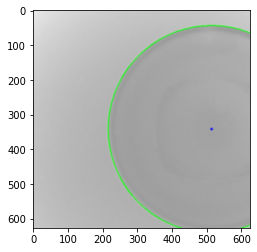

Loaded image from C:\Users\main\AllLenses\Allframedata1\00000072
BAD IMAGE
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000073
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000074
Label: 1
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000075
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000076
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000077
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000078
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000079
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000081
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000082
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000083
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000084
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000085
Label: 0
Loaded ima

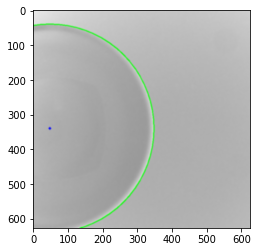

Loaded image from C:\Users\main\AllLenses\Allframedata1\00000103
BAD IMAGE
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000104
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000105
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000106
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000107
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000108
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000109
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000110
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000111
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000112
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000113
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000114
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000115
skipping 보류
Load

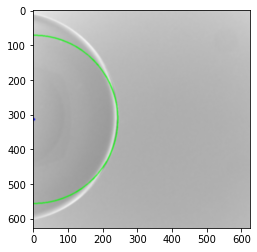

Loaded image from C:\Users\main\AllLenses\Allframedata1\00000122
BAD IMAGE
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000123
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000124
Label: 1
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000125
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000126
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000127
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000128
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000129
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000130
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000131
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000132
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000133
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000134
skipping 보류
Loaded image 

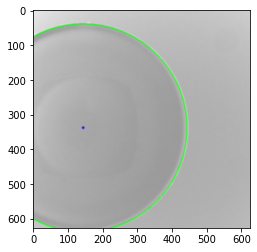

Loaded image from C:\Users\main\AllLenses\Allframedata1\00000157
BAD IMAGE
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000158
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000159
Label: 1
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000160
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000161
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000162
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000163
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000164
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000165
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000166
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000167
Label: 1
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000168
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000169
skipping 보류
Loaded image 

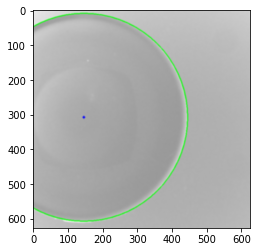

Loaded image from C:\Users\main\AllLenses\Allframedata1\00000201
BAD IMAGE
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000202
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000203
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000204
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000205
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000206
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000207
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000208
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000209
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000210
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000211
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000212
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000213
skipping 보류
Loaded image 

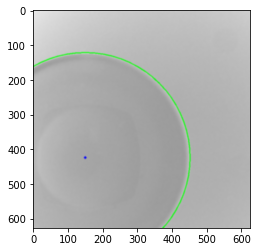

Loaded image from C:\Users\main\AllLenses\Allframedata1\00000224
BAD IMAGE
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000225
Label: 1
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000226
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000227
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000228
skipping 보류
x,y: 206 194


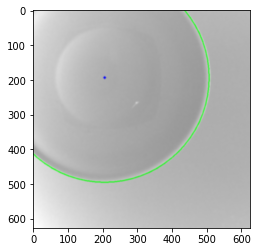

Loaded image from C:\Users\main\AllLenses\Allframedata1\00000229
BAD IMAGE
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000230
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000231
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000232
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000233
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000234
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000235
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000236
skipping 보류
x,y: 54 326


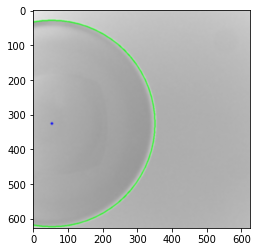

Loaded image from C:\Users\main\AllLenses\Allframedata1\00000237
BAD IMAGE
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000238
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000239
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000240
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000241
Label: 1
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000242
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000243
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000244
Label: 1
x,y: 6 344


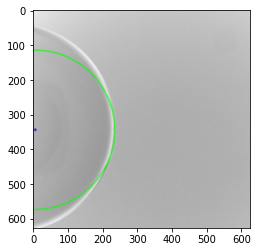

Loaded image from C:\Users\main\AllLenses\Allframedata1\00000245
BAD IMAGE
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000246
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000247
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000248
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000249
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000250
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000251
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000252
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000253
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000254
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000255
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000256
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000257
Label: 1
Loaded image 

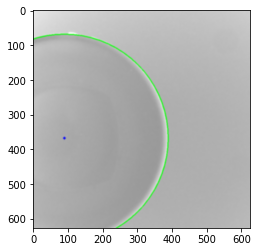

Loaded image from C:\Users\main\AllLenses\Allframedata1\00000299
BAD IMAGE
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000300
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000301
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000302
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000304
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000305
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000306
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000307
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000309
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000310
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000311
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000312
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000313
skipping 보류
Loaded image from C

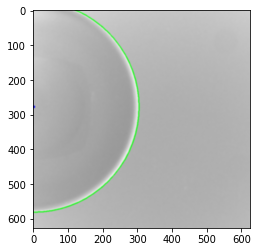

Loaded image from C:\Users\main\AllLenses\Allframedata1\00000395
BAD IMAGE
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000396
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000397
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000398
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000400
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000401
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000402
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000403
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000404
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000405
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000406
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000407
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000408
skipping 보류
Loaded ima

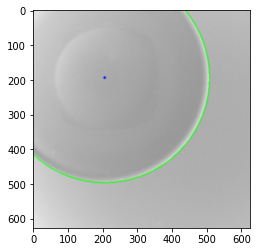

Loaded image from C:\Users\main\AllLenses\Allframedata1\00000476
BAD IMAGE
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000477
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000478
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000479
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000480
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000481
Label: 1
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000482
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000483
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000484
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000485
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000486
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000487
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000488
skipping 보류
Loaded image from C

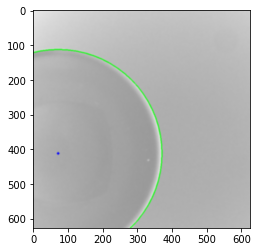

Loaded image from C:\Users\main\AllLenses\Allframedata1\00000523
BAD IMAGE
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000524
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000525
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000526
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000527
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000528
Label: 1
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000529
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000530
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000531
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000532
Label: 0
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000533
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000534
skipping 보류
Loaded image from C:\Users\main\AllLenses\Allframedata1\00000535
skipping 보류
Loaded image fro

UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node sequential/conv2d/Relu (defined at <ipython-input-10-835d73771a6a>:71) ]] [Op:__inference_train_function_658]

Function call stack:
train_function


In [10]:
count = 0
#momentum .5, .9, and .99, , momentum = 0.99
'''
model.compile(optimizer='adam',
              loss=tensorflow.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
'''

#loss='binary_crossentropy' vs categorical_crossentropy

directory = os.getcwd() + "\AllLenses"


path_list =[]

path_list.append(directory + "\Allframedata1")
#path_list.append(directory + "\Allframedata2")
#path_list.append(directory + "\Allframedata3")#bad lot
#path_list.append(directory + "\Allframedata4")
#path_list.append(directory + "\Allframedata5")
#path_list.append(directory + "\Allframedata6")

for path in path_list:
    folders = []
    subject_folder = os.scandir(path)
    print("Files and Directories in '% s'" % path) 

    for file in subject_folder: 
        if file.is_dir() or file.is_file(): #중간중간에 파일이 빠져있음
            folders.append(file.name)
            #print("There is folder:", file.name)

    x, y = getImagesandLabels(path, folders)
    print("# of images", len(x))
    print("# of labels", len(y))
    if count ==0:
        num_classes=2
        model = models.Sequential()
        model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(x[0].shape[0], x[0].shape[1], 3)))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Conv2D(32, (3, 3), activation='relu'))
        
        model.add(Flatten())
        model.add(Dense(num_classes))
        model.add(Activation('sigmoid'))

        model.summary()
        opt=tensorflow.keras.optimizers.Adagrad(lr=0.01) #SGD has too high of loss
        model.compile(loss='binary_crossentropy',
                      optimizer=opt,
                      metrics=['accuracy'])
        count+=1
    #datagen.fit(x)
    #for X_batch, Y_batch in datagen.flow(tuple_input, y, batch_size=25): # these are chunks of 32 samples
    #X_train, Y_train, X_test, Y_test = preprocess_XY(x, y) 
    #print("Y_train:", Y_train)
    #print("Y_test:", Y_test)
    images = np.asarray(x)
    labels = np.asarray(y)
    
    splitter =int(len(images)*.75)
    X_train = images[0:splitter]
    X_test = images[splitter:len(images)]
    Y_train = labels[0:splitter]
    Y_test = labels[splitter:len(labels)]
    
    #Y_train = Y_train.astype('float32').reshape((-1,1))
    #Y_test = Y_test.astype('float32').reshape((-1,1))
    Y_train = to_categorical(Y_train, num_classes = 2) #change 
    Y_test = to_categorical(Y_test, num_classes = 2) #change
    history = model.fit(X_train, Y_train, epochs=500, batch_size=16, verbose=1,validation_data=(X_test, Y_test))

    #  "Accuracy"
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','val'], loc='upper left')
    plt.show()
    # "Loss"
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','val'], loc='upper left')
    plt.show()

score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
print(images.shape)